In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import os

In [102]:
df = pd.read_csv('Energy_consumption.csv')

In [147]:
df.head()

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00          1              0         2.774699          5   
2022-01-01 01:00:00          1              1        21.831384          5   
2022-01-01 02:00:00          0              0         6.764672          5   
2022-01-01 03:00:00          0              1         8.623447          5   
2022-01-01 04:00:00          1              0         3.071969          5   

                     Holiday  EnergyConsumption  Hour  7-day-SMA  14-day-SMA  \
Timestamp                                                                      
2022-01-01 00:00:00        0          75.364373     0        NaN         NaN   
2022-01-01 01:00:00        0          83.401855     1        NaN         NaN   
2022-01-01 02:00:00        0          78.270888     2        NaN         NaN   
2022-01-01 03:00:00        0          56.519850     3        NaN         NaN   
2022-01-01 04:00:00        0          70.811732     4        NaN         NaN   

                        EWMA-7    EWMA-14  
Timestamp                                  
2022-01-01 00:00:00  75.364373  75.364373  
2022-01-01 01:00:00  77.373744  76.436038  
2022-01-01 02:00:00  77.598030  76.680684  
2022-01-01 03:00:00  72.328485  73.992573  
2022-01-01 04:00:00  71.949297  73.568461

In [133]:
df.info()

df.index.min(), df.index.max()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2022-01-01 00:00:00 to 2022-02-11 15:00:00
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1000 non-null   float64
 1   Humidity           1000 non-null   float64
 2   SquareFootage      1000 non-null   float64
 3   Occupancy          1000 non-null   int64  
 4   HVACUsage          1000 non-null   int64  
 5   LightingUsage      1000 non-null   int64  
 6   RenewableEnergy    1000 non-null   float64
 7   DayOfWeek          1000 non-null   int64  
 8   Holiday            1000 non-null   int64  
 9   EnergyConsumption  1000 non-null   float64
 10  Hour               1000 non-null   int32  
 11  7-day-SMA          994 non-null    float64
 12  14-day-SMA         987 non-null    float64
 13  EWMA-7             1000 non-null   float64
 14  EWMA-14            1000 non-null   float64
dtypes: float64(9), int32(1), int64(5)
me

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-11 15:00:00'))

In [105]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)

df['DayOfWeek'] = df.index.day_name()


In [106]:
df.isnull().sum()

Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

In [107]:
df['Holiday'].value_counts()

Holiday
No     533
Yes    467
Name: count, dtype: int64

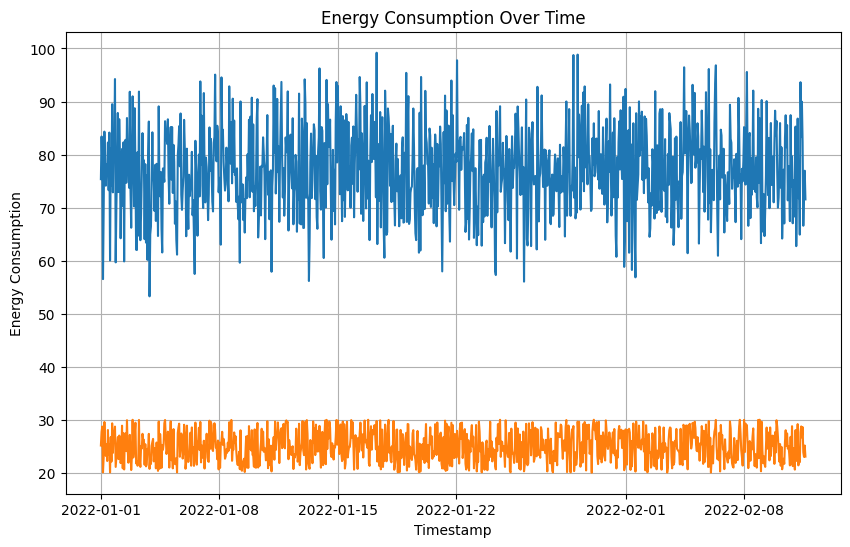

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['EnergyConsumption'], marker='')
plt.plot(df.index, df['Temperature'], marker='')
plt.title('Energy Consumption Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

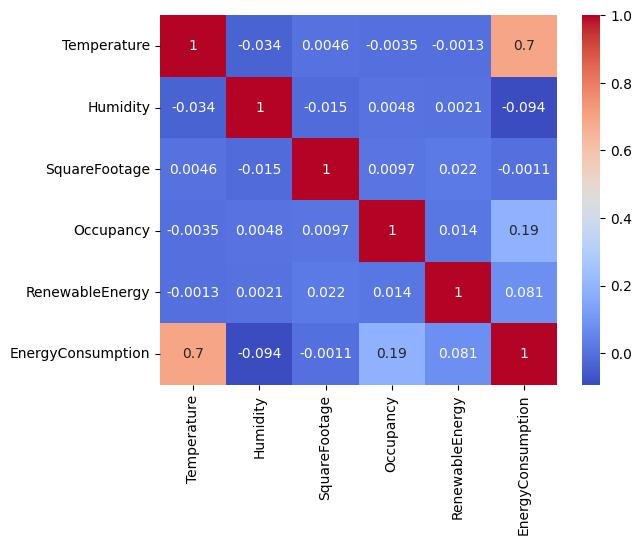

In [109]:
df_numeric = df.select_dtypes(include=['number'])
corr = df_numeric.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

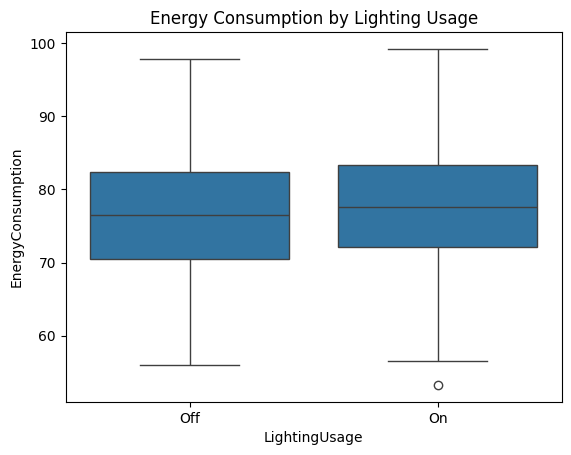

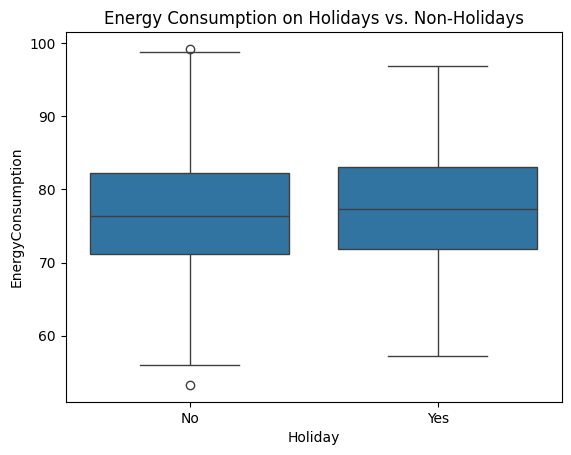

In [110]:
sns.boxplot(data=df, x='LightingUsage', y='EnergyConsumption')
plt.title('Energy Consumption by Lighting Usage')
plt.show()

sns.boxplot(data=df, x='Holiday', y='EnergyConsumption')
plt.title('Energy Consumption on Holidays vs. Non-Holidays')
plt.show()

<Axes: title={'center': 'Daily Average Energy Consumption'}, xlabel='Timestamp'>

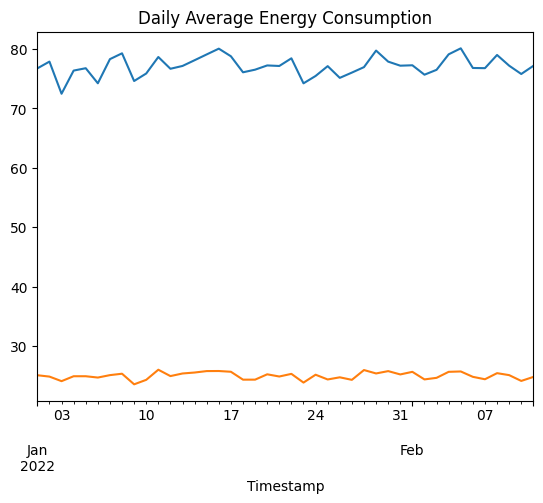

In [111]:
df.resample('D')['EnergyConsumption'].mean().plot(title="Daily Average Energy Consumption")
df.resample('D')['Temperature'].mean().plot(title="Daily Average Energy Consumption")

In [112]:
one_week_df = df.loc['2022-01-01':'2022-01-07']



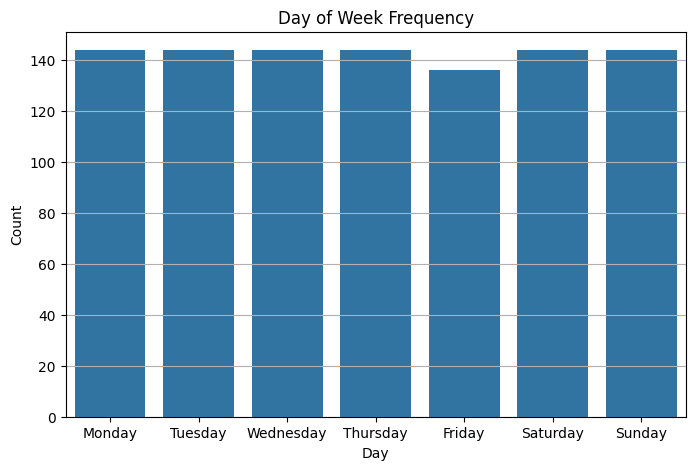

In [113]:
plt.figure(figsize=(8, 5))
sns.countplot(x='DayOfWeek', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of Week Frequency')
plt.xlabel('Day')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

In [114]:
ordinal_encoder = OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])
df['DayOfWeek'] = ordinal_encoder.fit_transform(df[['DayOfWeek']])
df['DayOfWeek'] = df['DayOfWeek'].astype(int)


In [115]:
df['LightingUsage'] = df['LightingUsage'].map({'Off': 0, 'On': 1})
df['HVACUsage'] = df['HVACUsage'].map({'Off': 0, 'On': 1})
df['Holiday'] = df['Holiday'].map({'No': 0, 'Yes': 1})

In [116]:
df.head()

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00          1              0         2.774699          5   
2022-01-01 01:00:00          1              1        21.831384          5   
2022-01-01 02:00:00          0              0         6.764672          5   
2022-01-01 03:00:00          0              1         8.623447          5   
2022-01-01 04:00:00          1              0         3.071969          5   

                     Holiday  EnergyConsumption  
Timestamp                                        
2022-01-01 00:00:00        0          75.364373  
2022-01-01 01:00:00        0          83.401855  
2022-01-01 02:00:00        0          78.270888  
2022-01-01 03:00:00        0          56.519850  
2022-01-01 04:00:00        0          70.811732

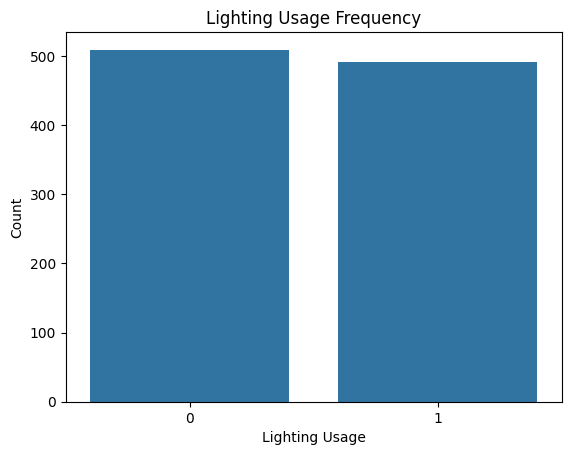

In [117]:
sns.countplot(x='LightingUsage', data=df, order=[0, 1])
plt.title('Lighting Usage Frequency')
plt.xlabel('Lighting Usage')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Timestamp'>

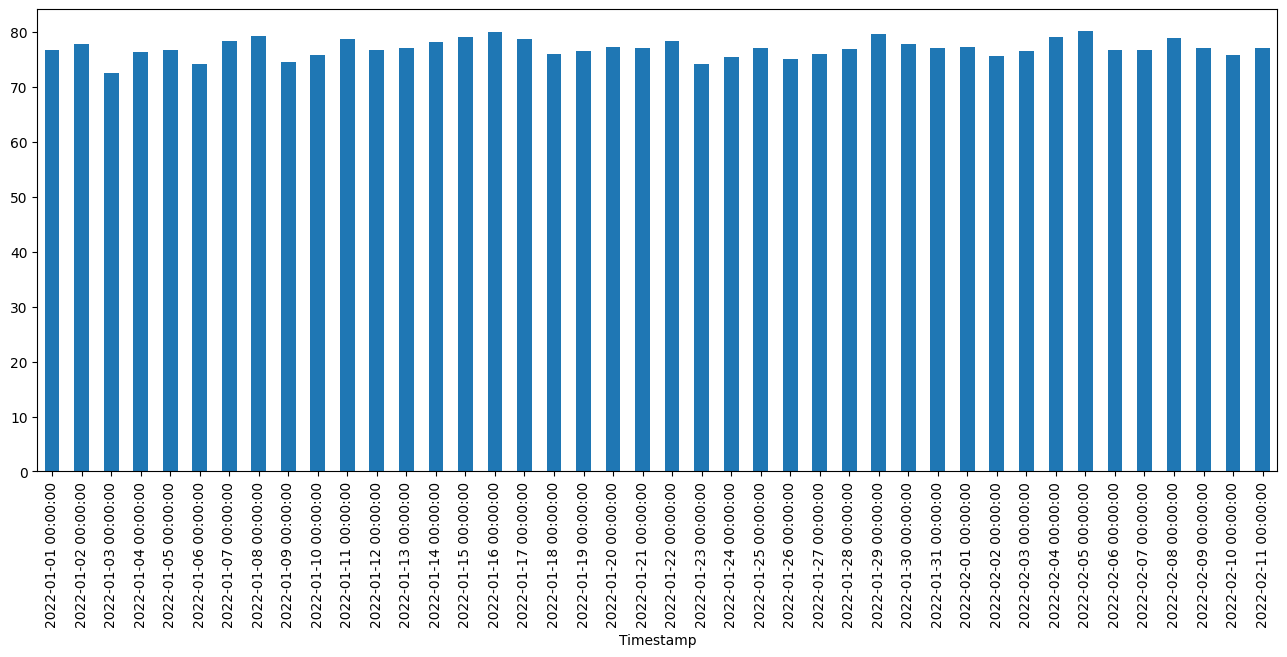

In [118]:
df ['EnergyConsumption']. resample('D').mean().plot.bar(figsize=(16,6))

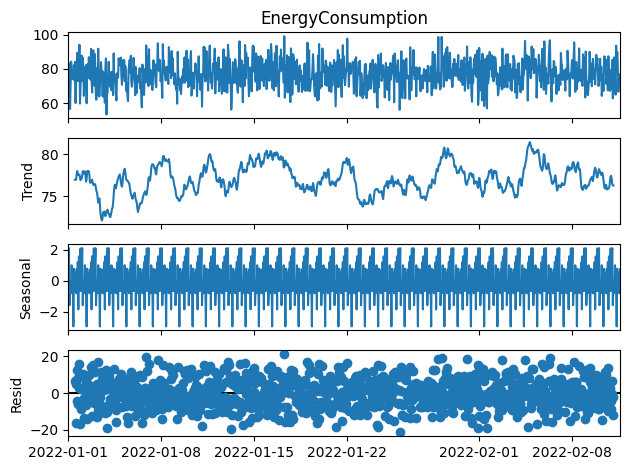

In [119]:
result = seasonal_decompose(df['EnergyConsumption'], model='additive', period=24)
result.plot();
plt.tight_layout()
plt.show()

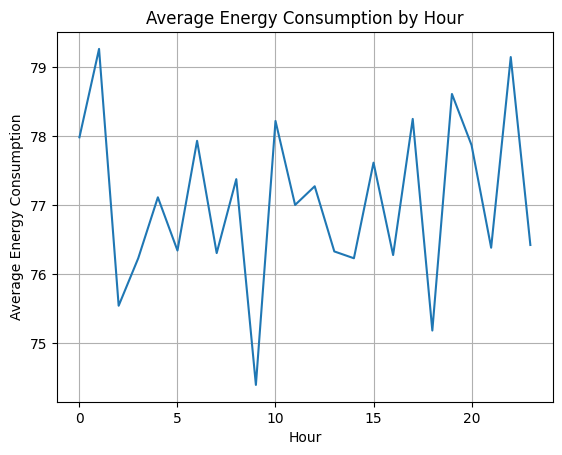

In [120]:
# Ensure the 'Hour' column exists
df['Hour'] = df.index.hour

# Group by 'Hour' and plot the average energy consumption
df.groupby('Hour')['EnergyConsumption'].mean().plot(kind='line', title='Average Energy Consumption by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Energy Consumption')
plt.grid(True)
plt.show()

In [121]:
df['7-day-SMA'] = df['EnergyConsumption'].rolling(window=7).mean()
df['14-day-SMA'] = df['EnergyConsumption'].rolling(window=14).mean()

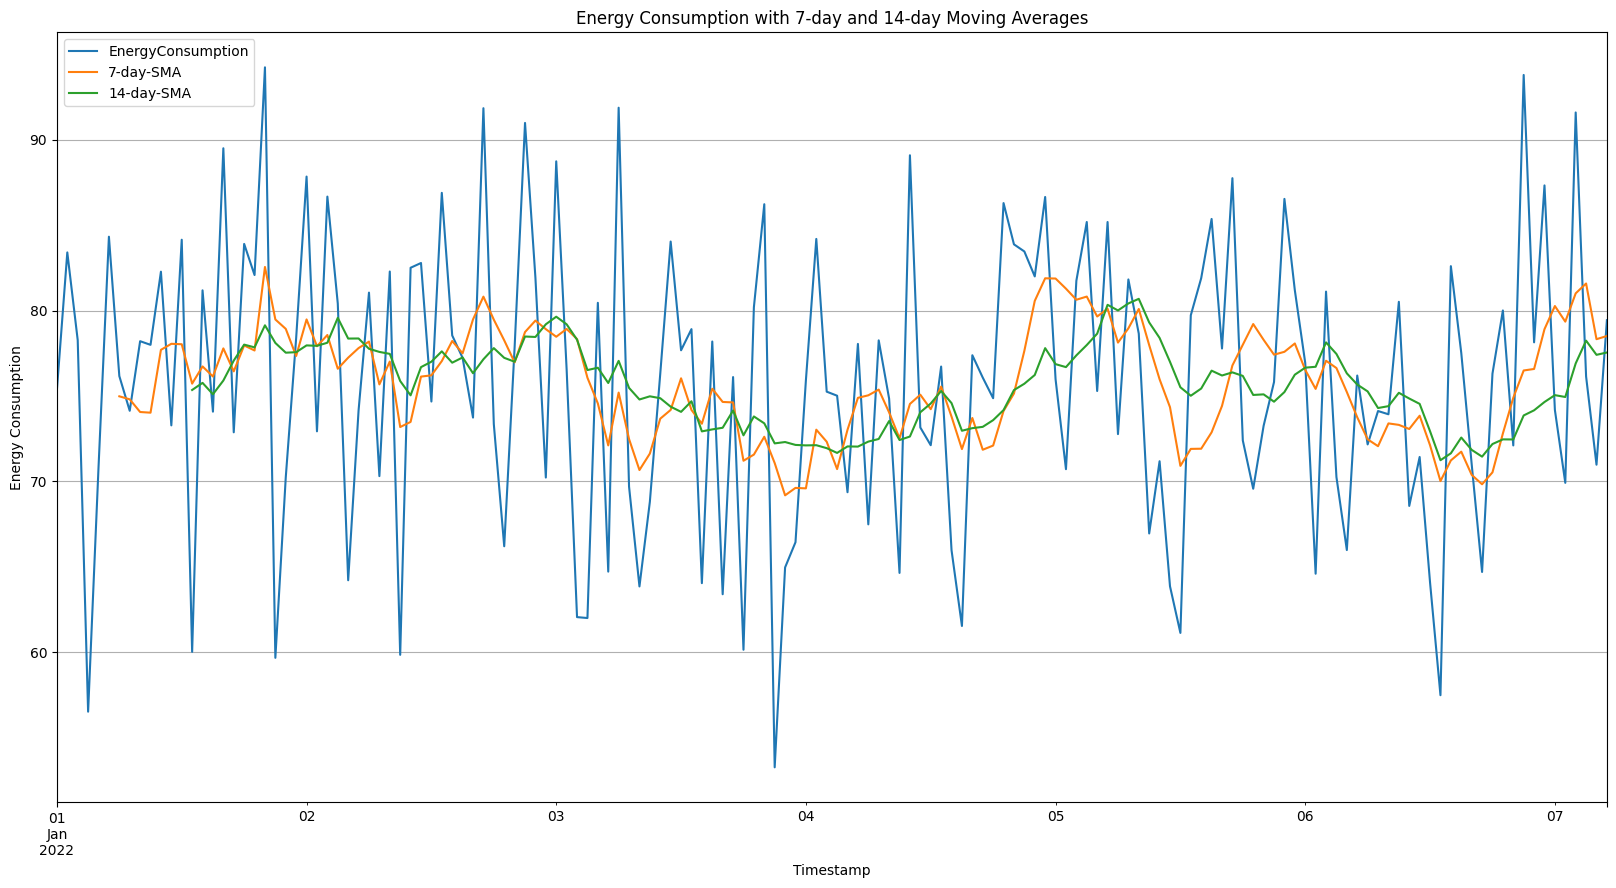

In [122]:
df[['EnergyConsumption', '7-day-SMA', '14-day-SMA']].iloc[:150].plot(figsize=(20, 10))
plt.title('Energy Consumption with 7-day and 14-day Moving Averages')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

In [123]:
# Add EWMA with a specified span
df['EWMA-7'] = df['EnergyConsumption'].ewm(span=7, adjust=False).mean()
df['EWMA-14'] = df['EnergyConsumption'].ewm(span=14, adjust=False).mean()

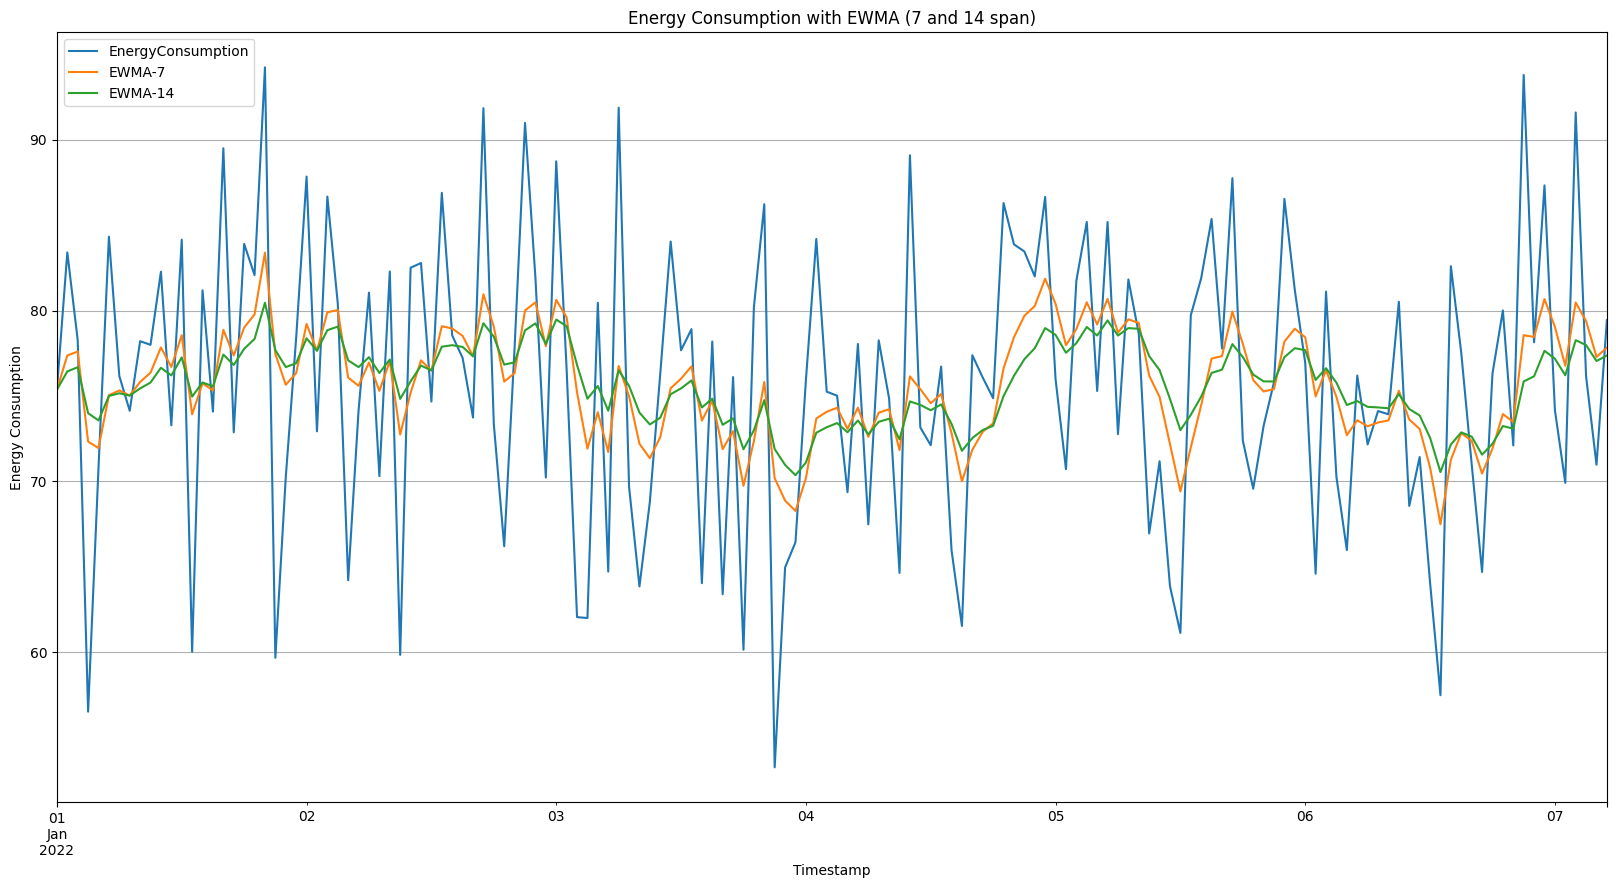

In [124]:
df[['EnergyConsumption', 'EWMA-7', 'EWMA-14']].iloc[:150].plot(figsize=(20, 10))
plt.title('Energy Consumption with EWMA (7 and 14 span)')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()

SES - Simple Exponential Smoothing

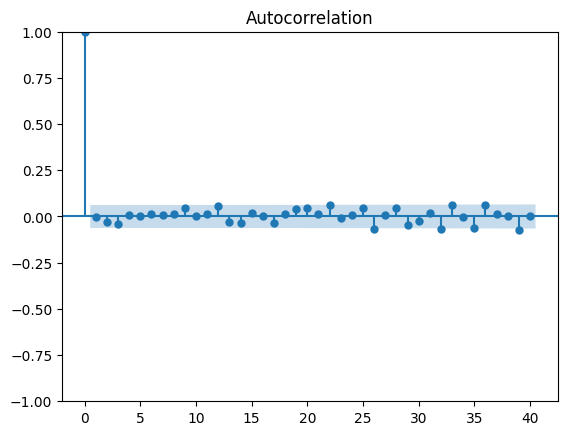

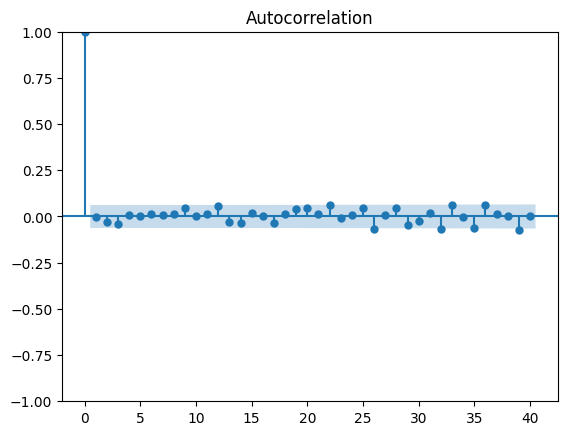

In [125]:
plot_acf(df['EnergyConsumption'].dropna(), lags=40)

In [126]:
# Test if HVACUsage helps predict EnergyConsumption
grangercausalitytests(df[['EnergyConsumption', 'Temperature']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9692  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9692  , df=1
parameter F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.0104  , p=0.9948  , df=2
likelihood ratio test: chi2=0.0104  , p=0.9948  , df=2
parameter F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=0.1598  , p=0.9838  , df=3
likelihood ratio test: chi2=0.1597  , p=0.9838  , df=3
parameter F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(0.0014833430370322716),
    np.float64(0.9692854338316828),
    np.float64(996.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.0014878109377462242),
    np.float64(0.9692315049607265),
    np.int64(1)),
   'lrtest': (np.float64(0.0014878098299959674),
    np.float64(0.9692315164093971),
    np.int64(1)),
   'params_ftest': (np.float64(0.0014833430370957076),
    np.float64(0.9692854338316828),
    np.float64(996.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.0051734003736255574),
    np.float64(0.9948399854285025),
    np.float64(993.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.01039889944184956),
    np.float64(0.9948140440209683),
    np.int64(2)),
   'lrtest': (np.float64(0.010398845265626733),
    np.float64(0.9948140709686023),
    np.int64(2)),
   'params_ftest': (np.float64(0.0051734003734409395),
    np.float64(0.9948399854286669),
    np.float64(993.0),
    2.0)},
   array([[0., 0.

In [127]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['EnergyConsumption'])  # or any other time series column
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -31.576934146718358
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4369127451400474), '5%': np.float64(-2.864437475834273), '10%': np.float64(-2.568312754566378)}


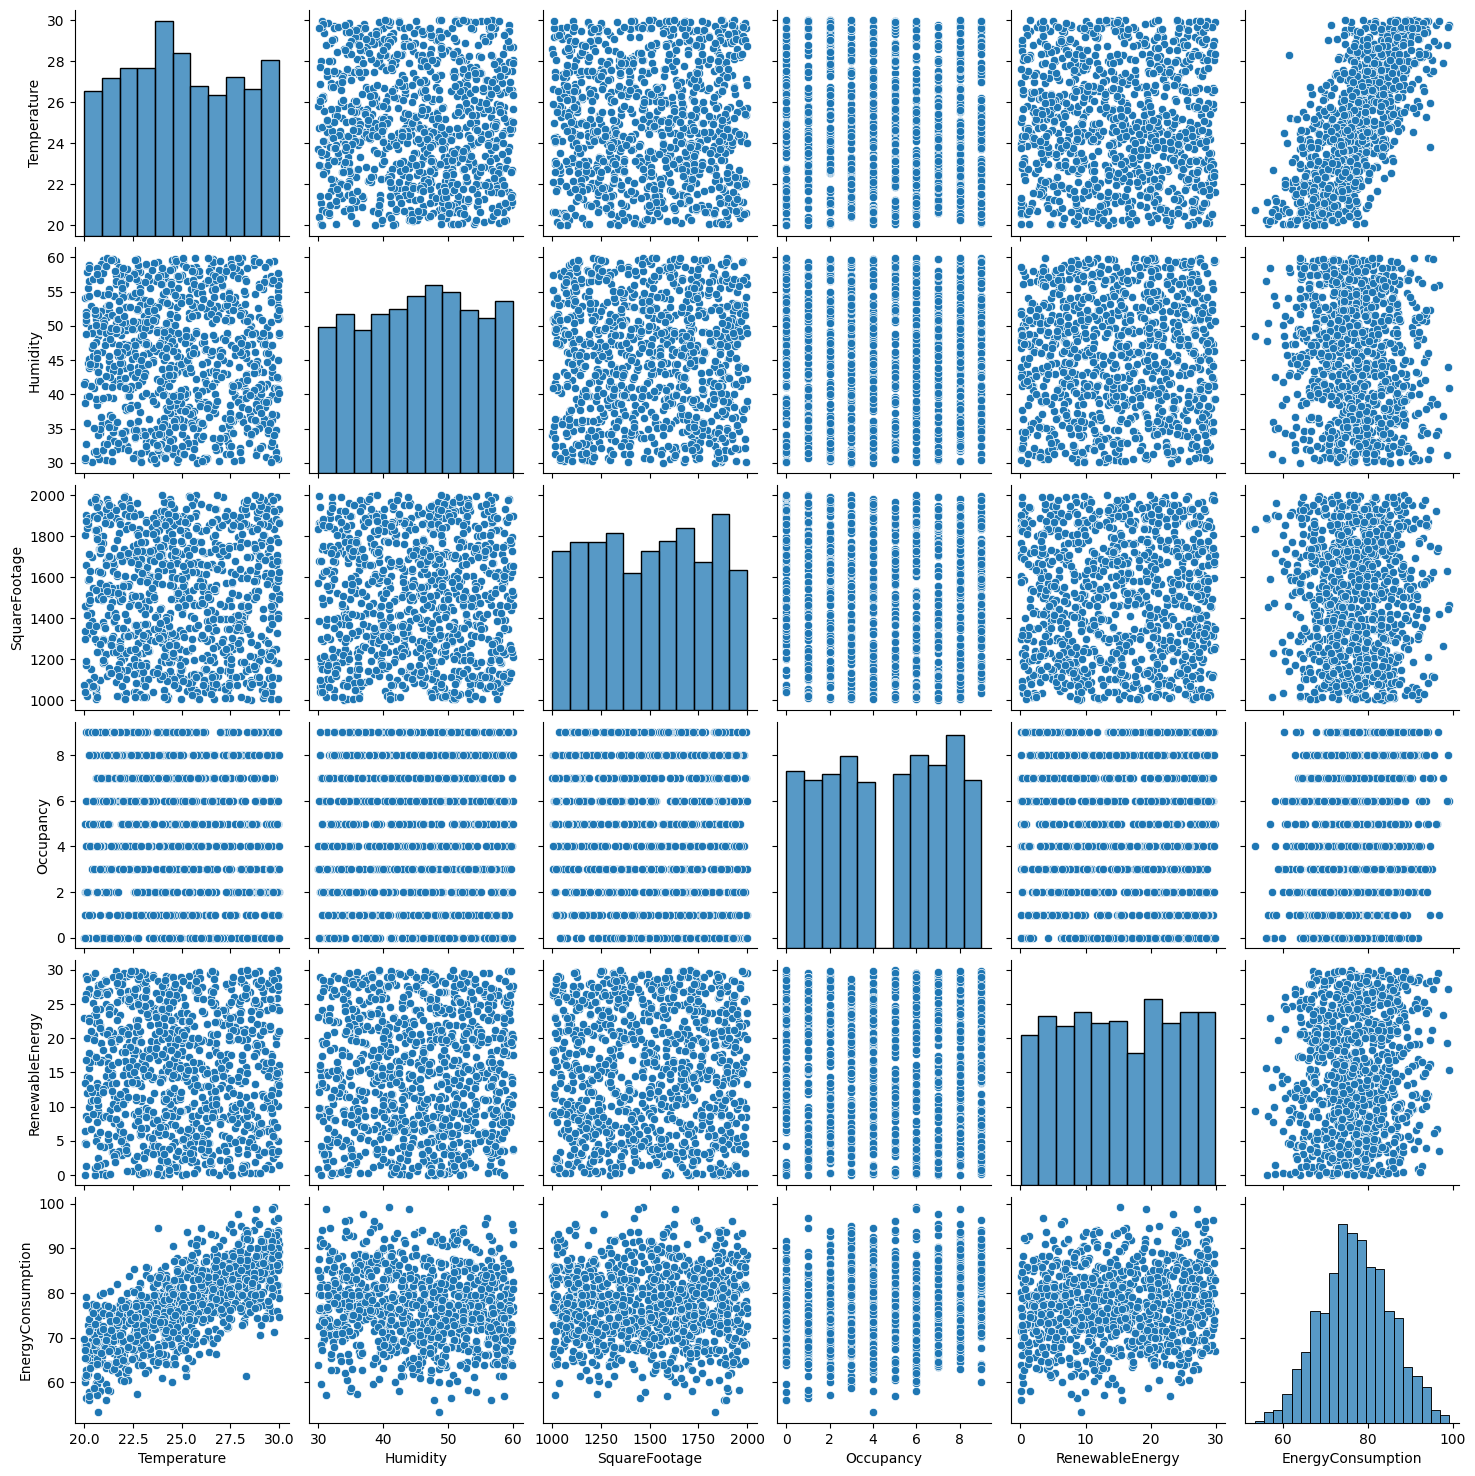

In [135]:
sns.pairplot(df[['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']])
plt.show()

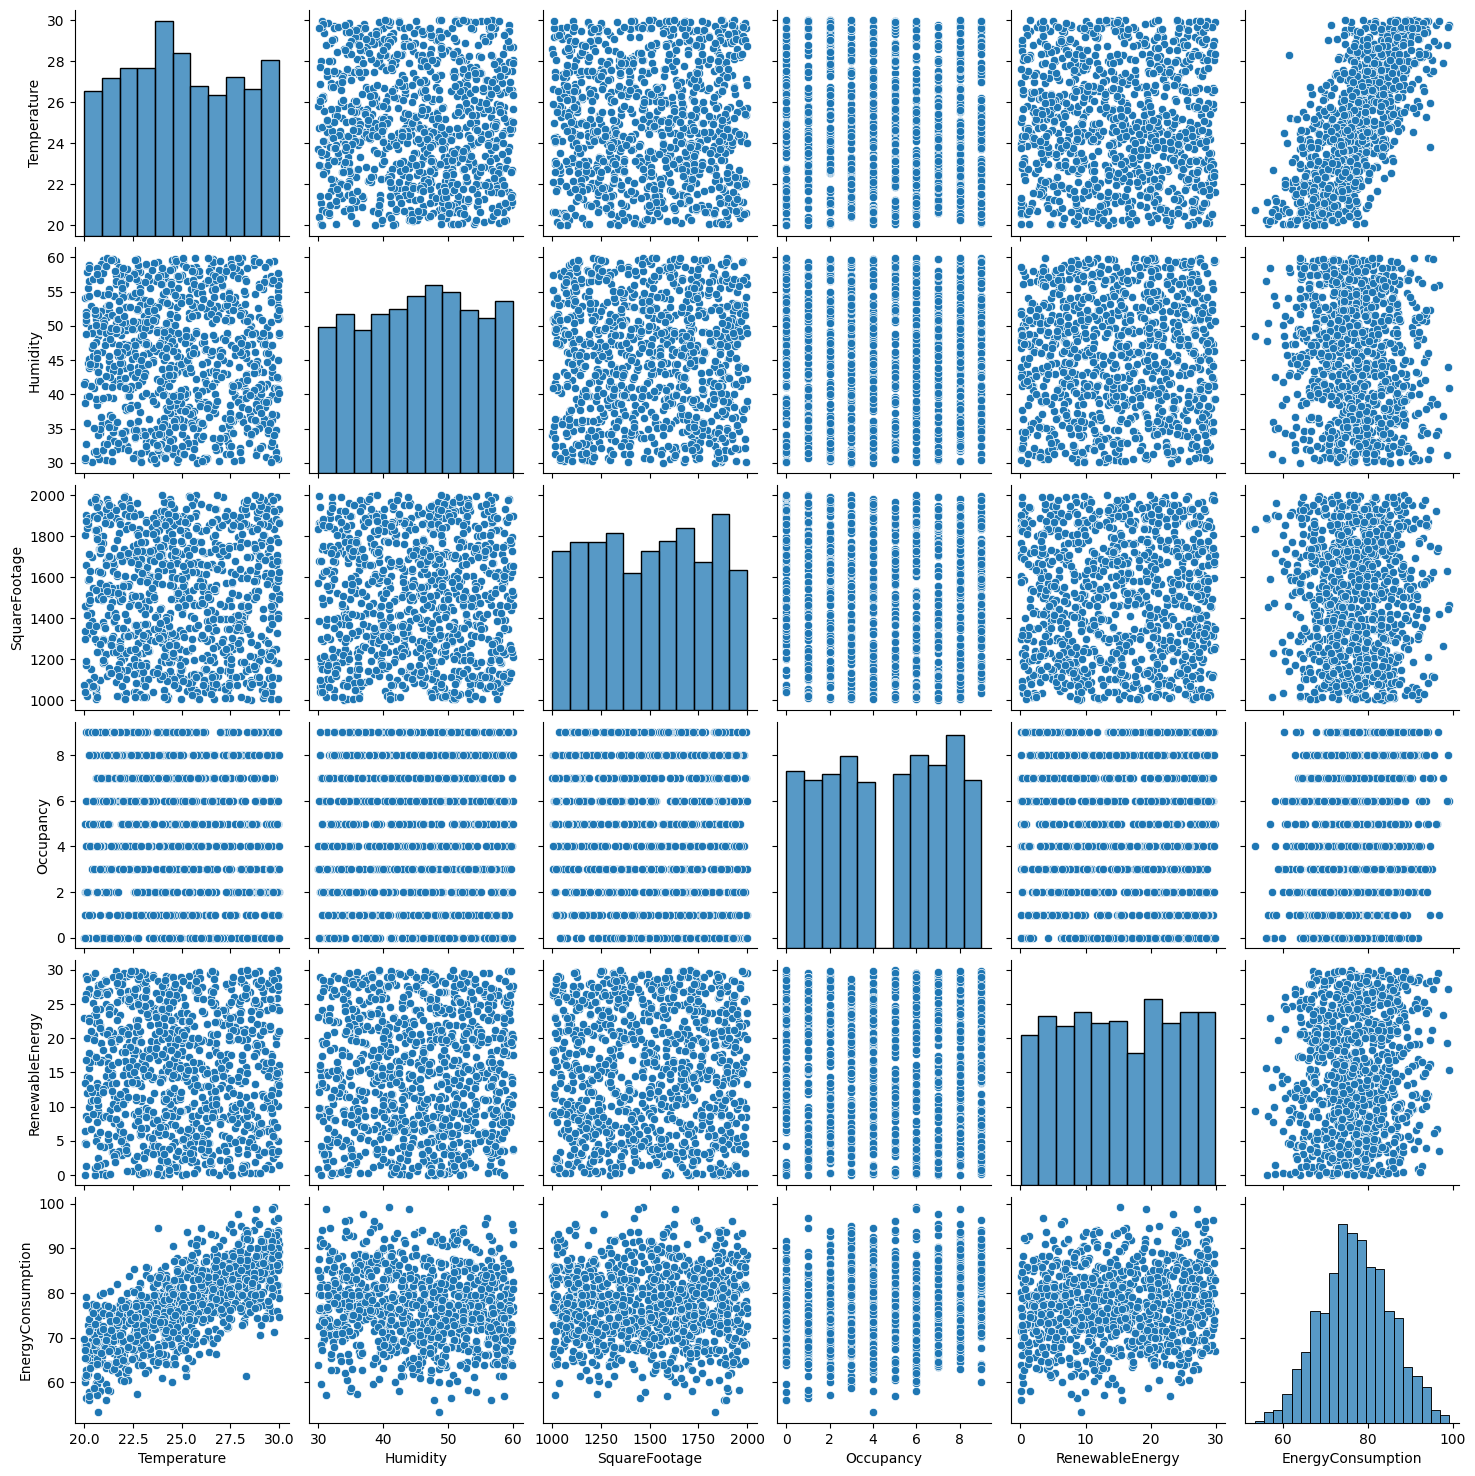

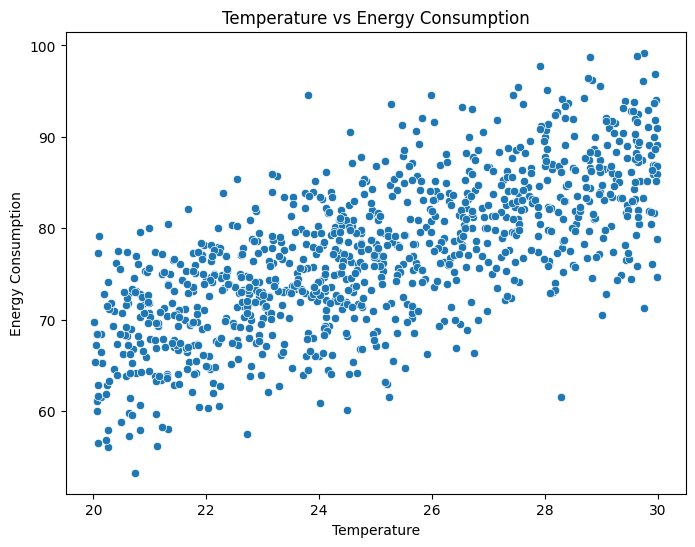

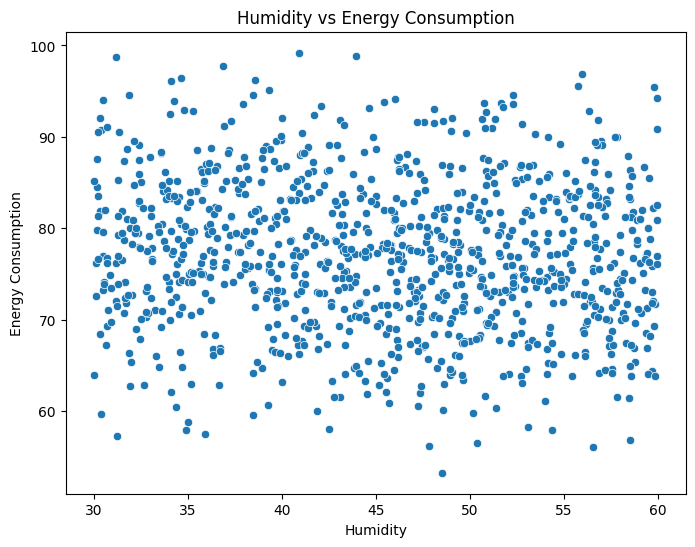

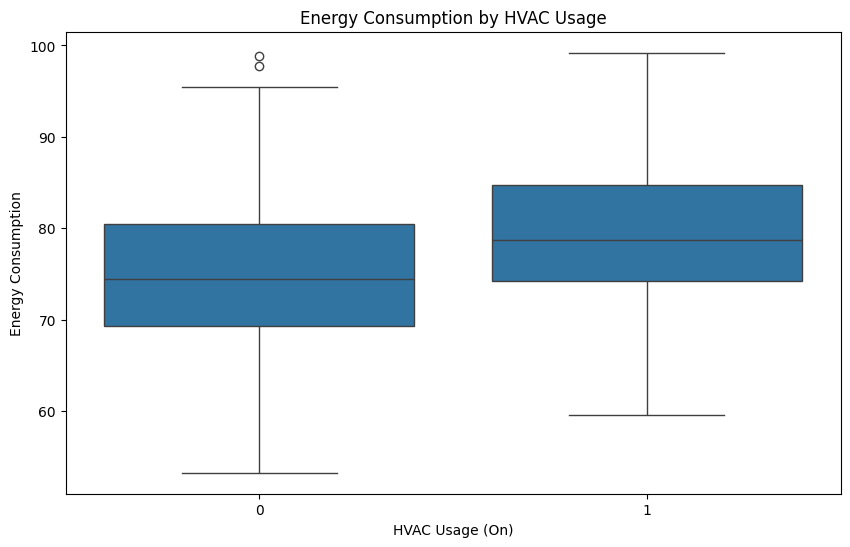

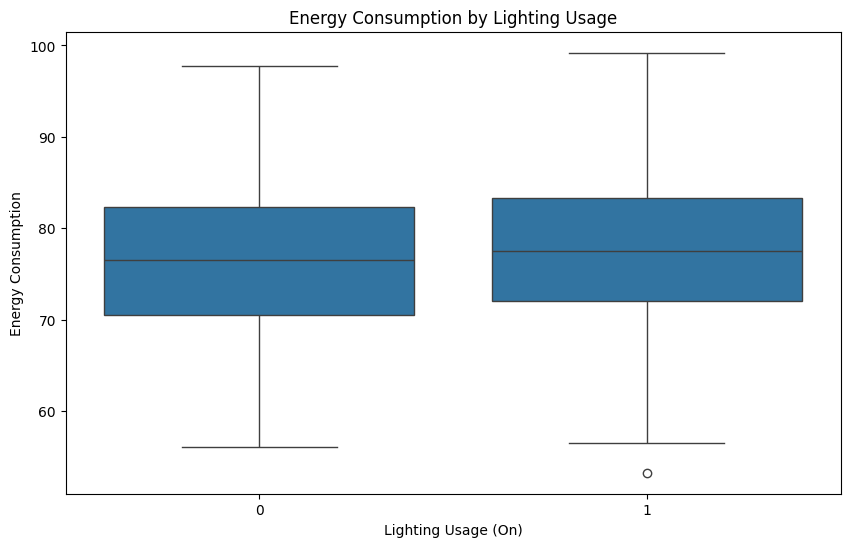

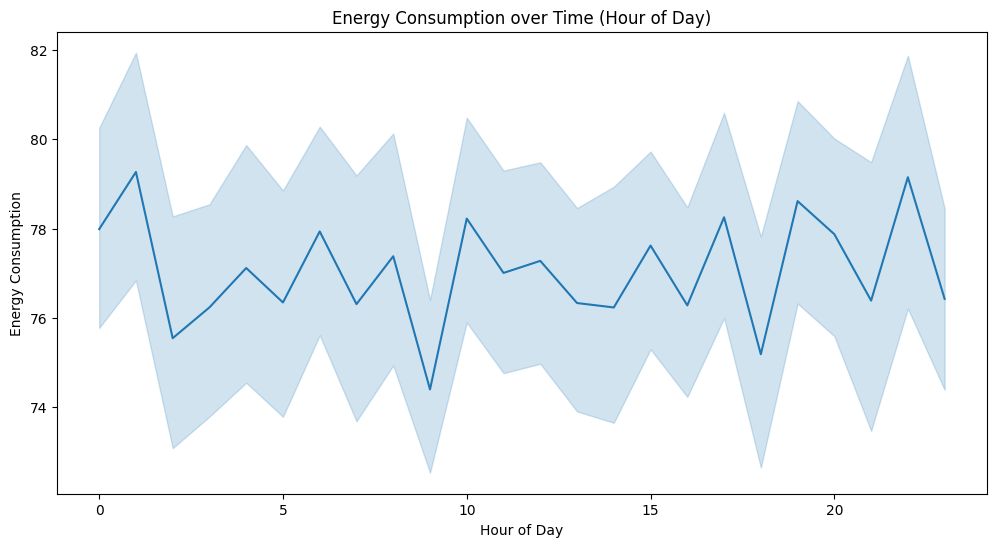

In [142]:
# Pairplot
sns.pairplot(df[['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']])
plt.show()

# Scatter Plots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Temperature', y='EnergyConsumption', data=df)
plt.title('Temperature vs Energy Consumption')
plt.xlabel('Temperature')
plt.ylabel('Energy Consumption')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Humidity', y='EnergyConsumption', data=df)
plt.title('Humidity vs Energy Consumption')
plt.xlabel('Humidity')
plt.ylabel('Energy Consumption')
plt.show()

# Box Plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='HVACUsage', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by HVAC Usage')
plt.xlabel('HVAC Usage (On)')
plt.ylabel('Energy Consumption')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='LightingUsage', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by Lighting Usage')
plt.xlabel('Lighting Usage (On)')
plt.ylabel('Energy Consumption')
plt.show()



# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='EnergyConsumption', data=df)
plt.title('Energy Consumption over Time (Hour of Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption')
plt.show()

In [144]:

# Plotly histogram
fig = px.histogram(df, x="Temperature", y="EnergyConsumption", marginal="rug",
                   hover_data=df.columns,
                   title='Histogram of Temperature vs Energy Consumption',
                   labels={'Temperature': 'Temperature (°C)', 'EnergyConsumption': 'Energy Consumption'})
fig.update_layout(bargap=0.1)  # Gap between bars

# Show plot
fig.show()

NameError: name 'px' is not defined

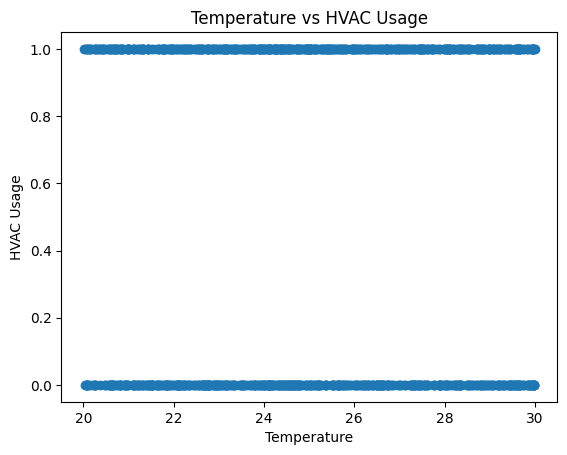

24.985589341683514
24.978575462501


In [ ]:
plt.plot(df['Temperature'], df['HVACUsage'], 'o')
plt.title('Temperature vs HVAC Usage')
plt.xlabel('Temperature')
plt.ylabel('HVAC Usage')
plt.show()

print(df[df['HVACUsage'] == 1] ['Temperature'].mean())
print(df[df['HVACUsage'] == 0] ['Temperature'].mean())




In [190]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    df['EnergyConsumption'].iloc[:-100],
    exog=df['Temperature'].iloc[:-100],
    order=(1,1,1),
    seasonal_order=(1,1,1,24)
)
results = model.fit()
#forecast = results.forecast(steps=24, exog=your_future_features)

/Users/tahamalik/Documents/ML/Git/SDS-CP027-watt-wise/submissions/team/taha-malik/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/tahamalik/Documents/ML/Git/SDS-CP027-watt-wise/submissions/team/taha-malik/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/tahamalik/Documents/ML/Git/SDS-CP027-watt-wise/submissions/team/taha-malik/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/SDS-CP027-watt-wise/submissions/team/taha-malik/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(

In [191]:
# Example: get the last known 24 values or supply a new future DataFrame
future_exog = df[['Temperature']].iloc[-100:]  # shape = (24, 1)
forecast = results.forecast(steps=100, exog=future_exog)

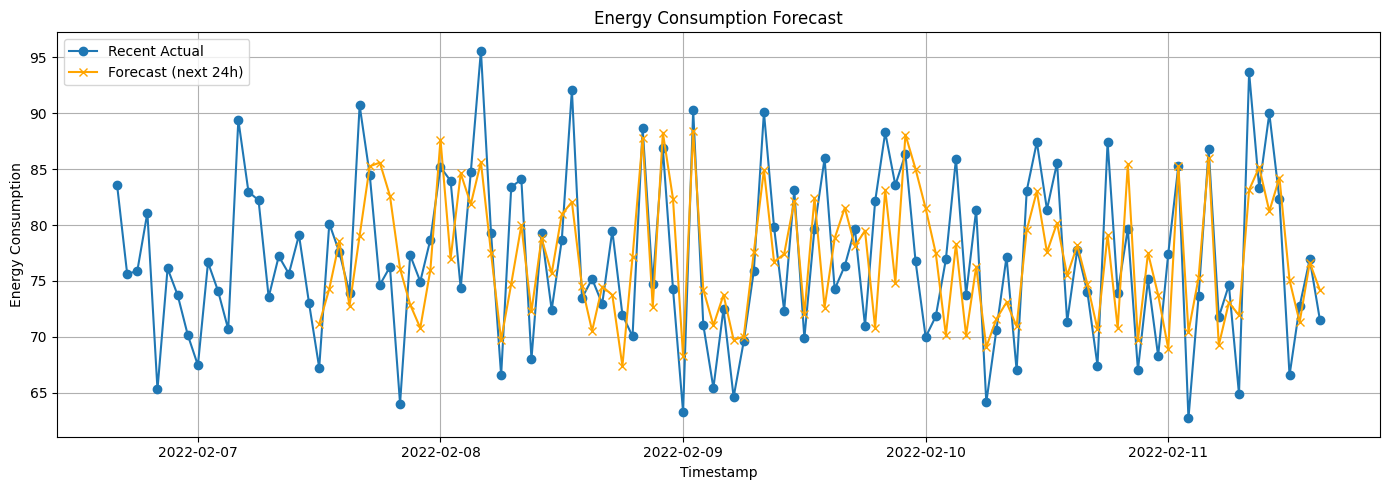

In [194]:
last_time = df.index[-100]
forecast_index = df.index[-100:]

# 2. Create a Series from the forecast
forecast_series = pd.Series(forecast, index=forecast_index)

# 3. Plot recent actuals + forecast
plt.figure(figsize=(14, 5))
plt.plot(df['EnergyConsumption'].iloc[-120:], label='Recent Actual', marker='o')
plt.plot(forecast_series, label='Forecast (next 24h)', marker='x', color='orange')
plt.title('Energy Consumption Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.head()
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00          1              0         2.774699          5   
2022-01-01 01:00:00          1              1        21.831384          5   
2022-01-01 02:00:00          0              0         6.764672          5   
2022-01-01 03:00:00          0              1         8.623447          5   
2022-01-01 04:00:00          1              0         3.071969          5   

                     Holiday  EnergyConsumption  Hour  7-day-SMA  14-day-SMA  \
Timestamp                                                                      
2022-01-01 00:00:00        0          75.364373     0        NaN         NaN   
2022-01-01 01:00:00        0          83.401855     1        NaN         NaN   
2022-01-01 02:00:00        0          78.270888     2        NaN         NaN   
2022-01-01 03:00:00        0          56.519850     3        NaN         NaN   
2022-01-01 04:00:00        0          70.811732     4        NaN         NaN   

                        EWMA-7    EWMA-14  
Timestamp                                  
2022-01-01 00:00:00  75.364373  75.364373  
2022-01-01 01:00:00  77.373744  76.436038  
2022-01-01 02:00:00  77.598030  76.680684  
2022-01-01 03:00:00  72.328485  73.992573  
2022-01-01 04:00:00  71.949297  73.568461

In [209]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

df['lag_1'] = df['EnergyConsumption'].shift(1)
df['hour'] = df.index.hour
#df['dayofweek'] = df.index.dayofweek
df = df.dropna()

# Step 2: Define features and target
X = df[['lag_1', 'Temperature', 'hour']].iloc[:-168]
y = df['EnergyConsumption'].iloc[:-168]

# Step 3: Time-based CV and modeling
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    model = XGBRegressor()
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[test_idx])
    #print("RMSE:", mean_squared_error(y.iloc[test_idx], y_pred, squared=False))

In [210]:
X_final = df[['lag_1', 'Temperature', 'hour']].iloc[-168:]
y_final = df['EnergyConsumption'].iloc[-168:]

# Retrain on full training set
final_model = XGBRegressor()
final_model.fit(X, y)

# Predict on final test set
y_pred_final = final_model.predict(X_final)

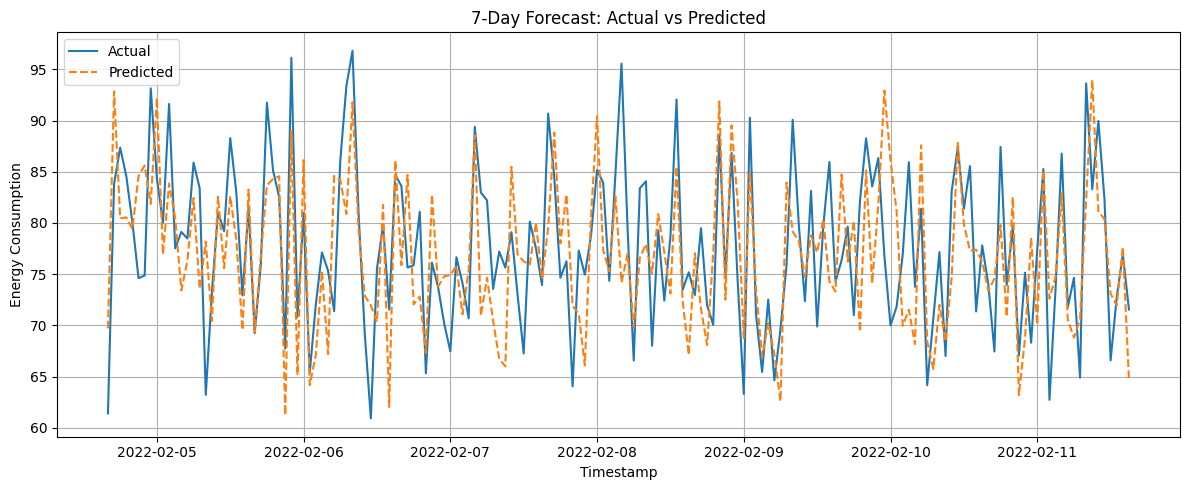

In [211]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred_final = pd.Series(y_pred_final, index=y_final.index)

plt.figure(figsize=(12, 5))
plt.plot(y_final.index, y_final, label='Actual')
plt.plot(y_pred_final.index, y_pred_final, label='Predicted', linestyle='--')
plt.title('7-Day Forecast: Actual vs Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [212]:
features = ['EnergyConsumption', 'Temperature']
df = df.dropna()[features]  # drop missing values

# Normalize (optional but recommended)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # target is EnergyConsumption
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, seq_len=24)

In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Remove last 24 time steps
X_future = X[-24:]
y_future = y[-24:]

X_model = X[:-24]
y_model = y[:-24]

#optional
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, shuffle=False)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

y_pred_future = model.predict(X_future)

TypeError: XGBModel.fit() got an unexpected keyword argument 'epochs'

In [ ]:
plt.plot(y_future, label='Actual')
plt.plot(y_pred_future, label='Forecast', linestyle='--')
plt.title("LSTM 24-hour Forecast")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X_test' is not defined